This notebook checks:
- librosa <=> tensorflow whole spectrogram creation from audio
- tensorflow spec creation from audio <=> tfrecord spec
- size 31 piecewise creation from time pieces <=> pieces from spectrogram from whole audio

In [2]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random

import argparse
import numpy as np
import pydub
import tensorflow as tf
if not tf.executing_eagerly():
    tf.enable_eager_execution()

# from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [3]:
tf.executing_eagerly()

True

In [4]:
import importlib

In [5]:
importlib.reload(win)

<module 'windows' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/windows.py'>

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as ipd
import librosa.display

In [7]:
from IPython.display import Audio

### Load data

In [87]:
TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v7.15/val_19680'
tfrecord_files_val = glob.glob(os.path.join(TF_RECORD_DIR, '*.tfrecord'))
tfrecord_file = tfrecord_files_val[0]

In [100]:
spec_h = 257 # expected

positive_examples = []
negative_examples = []
n_to_read = 10
librosa_specs = []
all_sounds = []
all_specs = []
class LimitExceded(Exception): pass
running_min = 1
running_max = 0

try:
    for tfrecord_file in tfrecord_files_val:
        for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
            eg_np = tf.train.Example.FromString(example)
            
            spec = np.array(eg_np.features.feature["spectrogram"].float_list.value)
            
            librosa_specs.append(spec.reshape((257,124)))
            running_min = min(running_min, spec.min())
            running_max = max(running_max, spec.max())
            if n_to_read == 1:
                print('Length of spec is {}, which is {} x {}'.format(len(spec), spec_h, len(spec) / float(spec_h)))
            
            audio_segment = pydub.AudioSegment(
                eg_np.features.feature["audio"].bytes_list.value[0], 
                frame_rate=16000,
                sample_width=2, 
                channels=1
            )
            y = audio_segment.get_array_of_samples()
            all_sounds.append(y)

            labs = np.array(eg_np.features.feature["spectrogram_label"].int64_list.value)
            if labs.max() == 1:
                positive_examples.append(y)
            else:
                negative_examples.append(y)

            n_to_read -= 1
            if n_to_read <= 0:
                raise LimitExceded
except LimitExceded:
    print('Found {} positive examples and {} negative examples'.format(len(positive_examples), len(negative_examples)))
    print('Spectrogram values are between {} and {}'.format(running_min, running_max))

Length of spec is 31868, which is 257 x 124.0
Found 1 positive examples and 9 negative examples
Spectrogram values are between 2.933431915153051e-06 and 2.6407272815704346


In [114]:
sound_i = -1

In [115]:
sound_i += 1
y = all_sounds[sound_i]
y = np.array(y).astype(np.float32) / 2**15
spec_from_tf_record = librosa_specs[sound_i]

In [116]:
Audio(y, rate=16000)

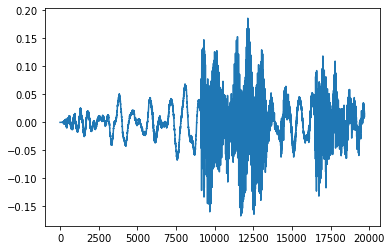

In [117]:
plt.plot(y)

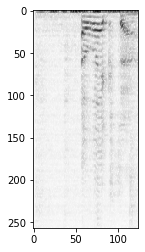

In [118]:
plt.imshow(spec_from_tf_record, cmap='Greys')

## Librosa

In [69]:
def samples2spectrogam(samples, win_length, hop_length, n_fft=512):
    """Magnitude of spectrogram.
    For labels use: sample_labels2spectrogam_labels.
    
    samples: 1-D array of values in range -1,1
    
    Returns a spectrogram that is n_fft // 2 + 1 high, and
    len(samples) // hop_length + 1 wide
    """
    spec = np.abs(librosa.core.stft(samples,
        win_length=win_length,
        hop_length=hop_length,
        n_fft=n_fft))
    
    # spec_db = librosa.amplitude_to_db(spec)
    # spec_db = np.clip(spec_db, -55, 65)
    # spec = librosa.db_to_amplitude(spec_db)
    
    # Stevens's power law for loudness, ok. it should be .33
    spec = spec**0.3
    
    return spec

## Tensorflow

In [70]:
from librosa.filters import get_window
from librosa.util import pad_center
from util.librosa import librosa_window_fn

In [71]:
def samples2spectrogam_tf(samples, win_length, hop_length, n_fft=512):
    """Magnitude of spectrogram.
    For labels use: sample_labels2spectrogam_labels.
    
    Interchangeable with samples2spectrogam.
    
    samples: 1-D array of values in range -1,1
    
    Returns a spectrogram that is n_fft // 2 + 1 high, and
    len(samples) // hop_length + 1 wide
    """
    x = tf.expand_dims(tf.cast(samples, tf.float32), 0) # batch, time
    x = tf.pad(x, ((0, 0),(n_fft//2, n_fft//2)), "REFLECT")
    
    def mywindow_fn(argi, dtype):
        """
        argi is the length of the window that is returned. In this case it is
        n_fft. The window returned will be a win_length window zero padded to
        be n_fft long.
        """
        del argi
        return tf.convert_to_tensor(librosa_window_fn(win_length, n_fft), dtype=dtype)
    
    spec = tf.signal.stft(
        x,
        frame_length=n_fft,
        frame_step=hop_length,
        fft_length=n_fft,
        window_fn=mywindow_fn,
        pad_end=False,
        name='STFT'
    )
    spec = tf.abs(spec)
    # Stevens's power law for loudness
    spec = spec**0.3
    
    return tf.transpose(tf.squeeze(spec)).numpy()

## Compare

In [127]:
librosa_spec = samples2spectrogam(y, 400, 160)
tf_spec = samples2spectrogam_tf(y, 400, 160)

In [120]:
((librosa_spec - tf_spec)**2).mean()

4.8828563e-13

In [121]:
def err(a,b):
    return (np.abs(librosa_spec - tf_spec)).max()

In [122]:
for z in all_sounds:
    z = np.array(z) / 2**15
    librosa_spec = samples2spectrogam(z, 400, 160)
    tf_spec = samples2spectrogam_tf(z, 400, 160)
    print(err(librosa_spec,tf_spec))

6.8463385e-05
2.0697713e-05
5.5134296e-06
8.486211e-06
2.7496368e-05
1.5057623e-05
4.494004e-05
8.738041e-05
6.2732026e-05
1.2725592e-05


### Compare to spec from file

In [128]:
((spec_from_tf_record.reshape((257,124)) - tf_spec)**2).mean()

1.3188893250304158e-06

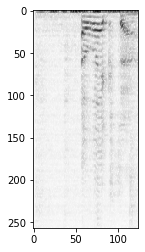

In [129]:
plt.imshow(spec_from_tf_record.reshape((257,124)), cmap='Greys')

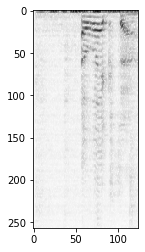

In [126]:
plt.imshow(spec_from_tf_record, cmap='Greys')

## How to batch it in smaller chunks

In [130]:
n_fft = 512
hop_length = 160
win_length = 400

In [131]:
y_ = np.pad(y, int(n_fft // 2), mode='reflect')
batch_item_length = n_fft-hop_length + hop_length*31
n_items_in_y = (len(y_) - batch_item_length) // hop_length


In [132]:
batched_input = []
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(y_[start:end])

In [133]:
def mywindow_fn(argi, dtype):
    """
    argi is the length of the window that is returned. In this case it is
    n_fft. The window returned will be a win_length window zero padded to
    be n_fft long.
    """
    del argi
    return tf.convert_to_tensor(librosa_window_fn(win_length, n_fft), dtype=dtype)

spec = tf.signal.stft(
    np.array(batched_input, dtype=np.float32),
    frame_length=n_fft,
    frame_step=hop_length,
    fft_length=n_fft,
    window_fn=mywindow_fn,
    pad_end=False,
    name='STFT'
)
spec = tf.abs(spec)
# Stevens's power law for loudness
spec = spec**0.3

tf_spec_whole_piecewise = tf.transpose(spec, perm=[0,2,1]).numpy()

In [134]:
# want to replicate subsets of tf_spec from subsets of y
tf_spec_whole = samples2spectrogam_tf(y, 400, 160)
tf_spec_whole_batched = []
for i in range(n_items_in_y):
    start = i
    end = start + 31
    tf_spec_whole_batched.append(tf_spec_whole[:,start:end])
tf_spec_whole_batched = np.array(tf_spec_whole_batched)

In [135]:
((tf_spec_whole_batched - tf_spec_whole_piecewise)**2).sum()

0.0